In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy.fftpack import dct, idct
from skimage import data

im = data.camera()/255.0
plt.gray()
%matplotlib inline

# Basis representations of images
## DCT
The DCT of an image $x$ is defined as 
$$
X_{k_1, k_2} \propto \sum_{n_2=0}^{N-1} \sum_{n_1=0}^{N-1} x_{n_1, n_2} \cos\left(\frac{\pi}{N}\left( n_1+\frac{1}{2}\right) k_1 \right)\cos\left(\frac{\pi}{M}\left( n_2+\frac{1}{2}\right) k_2 \right)
$$
This is a decomposition into basis functions of the form $$
\cos\left(\frac{\pi}{N}\left( n_1+\frac{1}{2}\right) k_1 \right)\cos\left(\frac{\pi}{M}\left( n_2+\frac{1}{2}\right) k_2 \right)
$$
These functions are orthogonal, if $k_1$ or $k_2$ are not equal between two different signals. We can see that if $k_1$ and $k_2$ are equal for two vectors, their inner product becomes that of $\cos^2$ which is strictly positive, so the result will be nonzero. Otherwise, it is a sum of periodic functions over their period, so it becomes zero.

## Wavelet
Haar wavelets are another form of basis for images. A DCT or other smooth transform will require high frequency to retain edges, so it is difficult to compress images with sharp edges. This is due to the smoothness of the cosine function. Haar wavelets have a very sharp edge, so they can efficiently represent functions that are jagged and have large jumps, while DCT would be less efficient in this case.
The general idea behind Haar wavelets is that any function can be represented by transforms of the mother wavelet function $\psi$, which takes on 1 if x is between 0 and 1/2, takes on -1 if x is between 1/2 and 1, and zero otherwise. We can then take functions of the form $2^{n/2}\psi(2^n x-k)$, which serve as an orthogonal basis for continuous real functions.

## Observations
When plotting the Haar and DCT bases, we can immediately see that the Haar wavelet is more local, while the DCT basis is much less compact. This means that if functions behave similarly to how the DCT basis expects (smooth, periodic/uniform), then it can very efficiently represent images, while the Haar will do better with images with sharp, local features. As a final observation, we can see that the DCT appears to more efficiently represent the cameraman image than the Haar transform does, as the distribution is appears to have more weight centered

In [25]:
def basis_fn(height, width, i, j):
    k, l = np.mgrid[0:height, 0:width]
    return np.cos(np.pi * (k+1/2) * i/height) * np.cos(np.pi * (l+1/2) * j/width) * (2/np.sqrt(height*width))
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

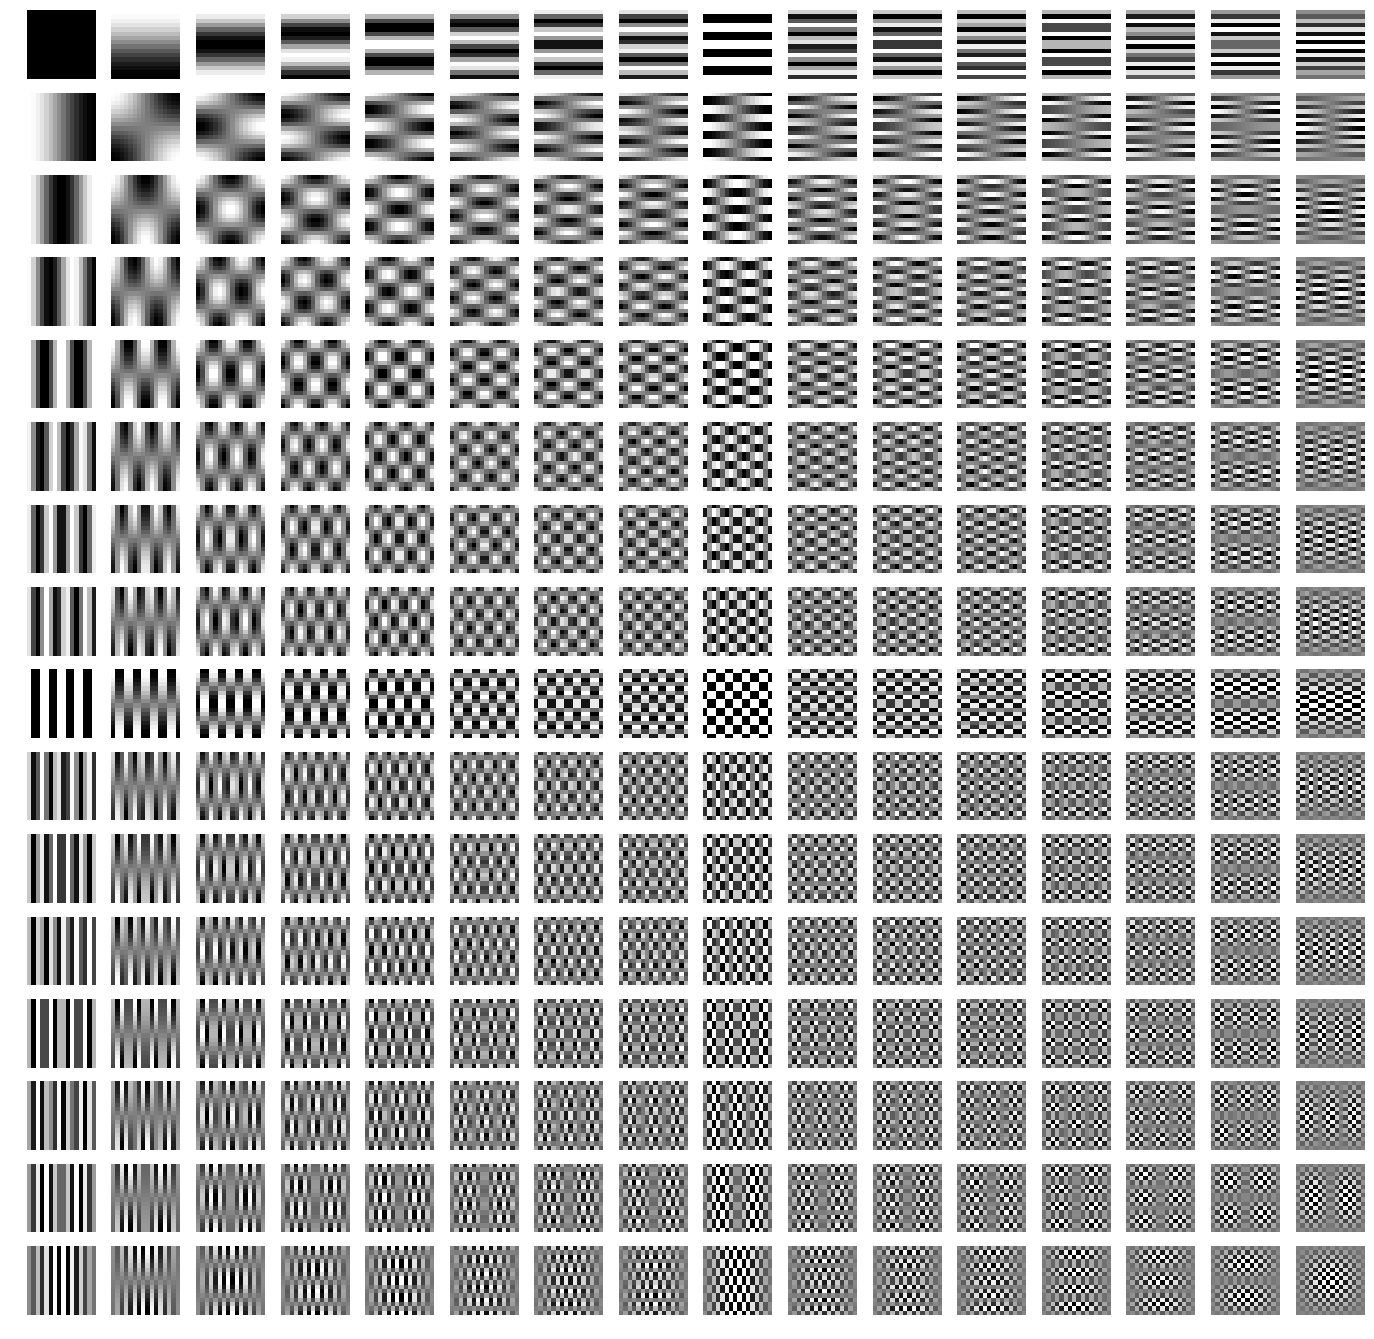

In [3]:
N = 16
a = np.zeros((N, N))
plt.figure(figsize=(24,24))
for j in range(N):
    for i in range(N):
        ax = plt.subplot(N,N,i + j*N+1)
        a[i, j] += 1
        ax.imshow(basis_fn(N, N, i, j))
        a[i, j] -= 1
        ax.axis('off')

In [7]:
import pywt

In [21]:
haar_basis = []
ores = pywt.wavedec2(np.ones((16, 16)), 'haar')
ores[0][:] = 1
haar_basis.append(pywt.waverec2(ores, 'haar'))
ores[0][:] = 0
for i in range(1, len(ores)):
    for j in range(3):
        for ix in np.ndindex(*ores[i][j].shape):
            ores[i][j][ix] = 1
            haar_basis.append(pywt.waverec2(ores, 'haar'))
            ores[i][j][ix] = 0

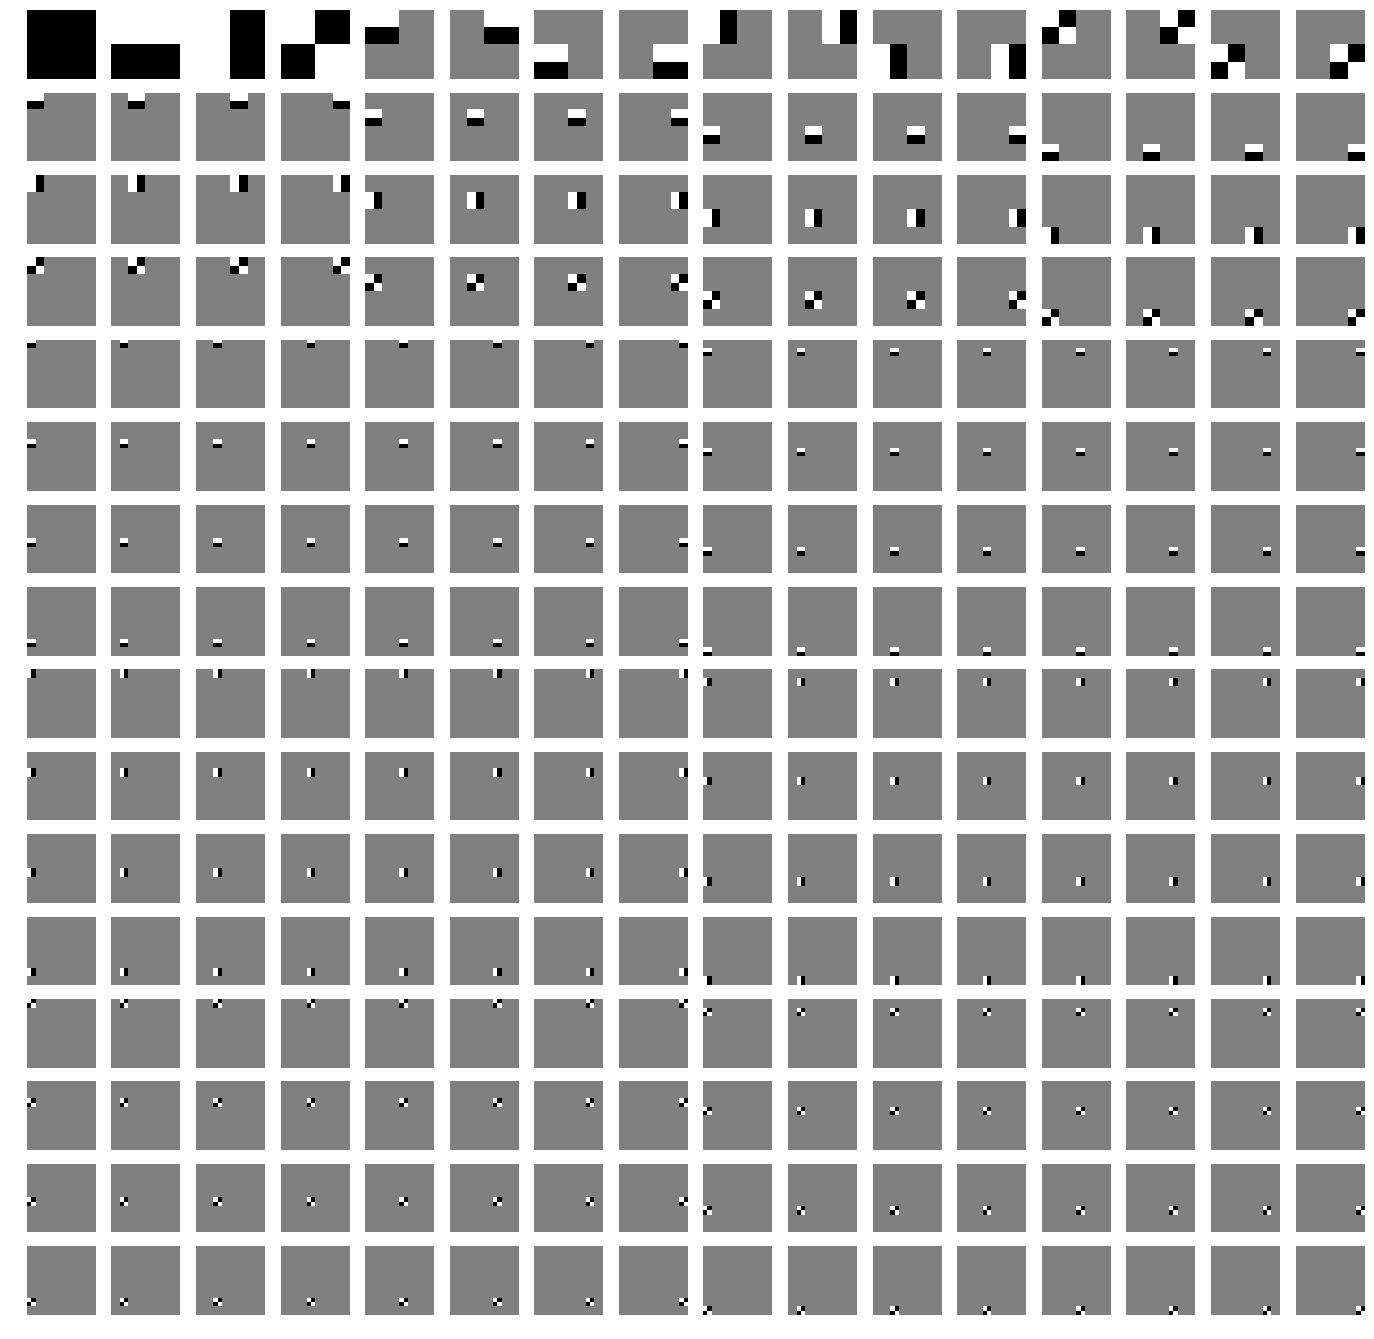

In [23]:
N = 16
plt.figure(figsize=(24,24))
for j in range(N**2):
    ax = plt.subplot(N,N, j+1)
    ax.imshow(haar_basis[j])
    ax.axis('off')

Text(0.5,1,'Haar histogram')

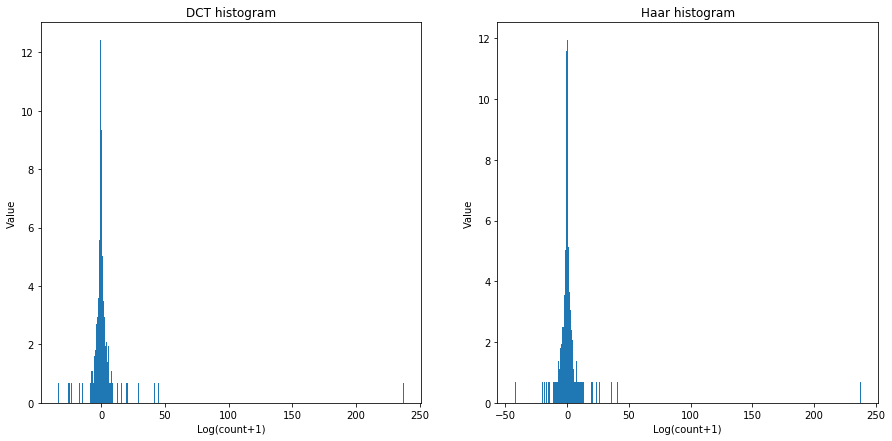

In [50]:
plt.figure(figsize=(15, 7))

vs = dct2(im).reshape(-1)
vs2 = pywt.wavedec2(im, 'haar')
vs2[0] = vs2[0][0]
for i in range(1, len(vs2)):
    vs2[i] = np.concatenate(vs2[i], axis=1).reshape(-1)
vs2 = np.concatenate(vs2, axis=-1)

ax = plt.subplot(1, 2, 1)
counts, bins = np.histogram(vs, bins=1000)
counts = np.log(counts+1)
ax.bar(bins[:-1], counts)
ax.set_xlabel('Log(count+1)')
ax.set_ylabel('Value')
ax.set_title('DCT histogram')

ax = plt.subplot(1, 2, 2)
counts, bins = np.histogram(vs2, bins=1000)
counts = np.log(counts+1)
ax.bar(bins[:-1], counts)
ax.set_xlabel('Log(count+1)')
ax.set_ylabel('Value')
ax.set_title('Haar histogram')